In [ ]:
!git clone https://github.com/facebookresearch/dinov2.git
%cd dinov2
!pip install -e .  # Installs the repo as a Python module

Cloning into 'dinov2'...
remote: Enumerating objects: 535, done.
remote: Total 535 (delta 0), reused 0 (delta 0), pack-reused 535 (from 1)
Receiving objects: 100% (535/535), 1.77 MiB | 3.80 MiB/s, done.
Resolving deltas: 100% (259/259), done.
/content/dinov2
Obtaining file:///content/dinov2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dinov2 to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement xformers==0.0.18 (from dinov2) (from versions: 0.0.1

In [ ]:
! pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.8 MB/s 

### load waterbird data

In [ ]:
# Cell 1: Upload your Kaggle API token
from google.colab import files
files.upload('')  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sohamtolwala","key":"e4532bc8b9072bb373c888e0657ef0c4"}'}

In [ ]:
# Cell 2: Setup Kaggle API
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Cell 3: Download the Waterbirds dataset
!kaggle datasets download -d bahardibaie/waterbird
!unzip waterbird.zip -d waterbirds_data

Streaming output truncated to the last 5000 lines.
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0001_110632.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0002_110606.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0003_110672.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0005_110911.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0008_110536.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0009_797256.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0010_797262.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_colored_Sparrow/Clay_Colored_Sparrow_0014_797248.jpg  
  inflating: waterbirds_data/waterbird/dataset/117.Clay_color

### base code trials

In [ ]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
from functools import partial
import math
from collections import OrderedDict

class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.metadata = self.metadata[self.metadata['split'] == split]
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])  # for environment id
        return image, label, place


In [ ]:
# Training and eval transforms (reuse from ERM)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [ ]:
import torch.nn.functional as F
from torch.autograd import grad

def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()

def irm_train_epoch(model, device, loaders, optimizer, epoch):
    model.train()
    dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))
    penalty_multiplier = epoch ** 1.6

    total_error = 0.0
    total_penalty = 0.0
    num_batches = 0

    for batches in zip(*loaders):
        optimizer.zero_grad()
        error = 0.0
        penalty = 0.0

        for data, target, _ in batches:
            data, target = data.to(device), target.to(device).float()
            out = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(out * dummy_w, target, reduction='none')
            penalty += compute_irm_penalty(loss, dummy_w)
            error += loss.mean()

        loss = error + penalty_multiplier * penalty
        loss.backward()
        optimizer.step()

        total_error += error.item()
        total_penalty += penalty.item()
        num_batches += 1

    print(f"[Epoch {epoch}] ERM loss: {total_error / num_batches:.4f} | IRM penalty: {total_penalty / num_batches:.4f} | λ: {penalty_multiplier:.2f}")


In [ ]:
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst


In [ ]:
# ViT-Small (patch size 8) definition
class PatchEmbed(nn.Module):
    """2D Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # shape: [B, C, H/P, W/P]
        x = x.flatten(2).transpose(1, 2)  # shape: [B, num_patches, embed_dim]
        return x

class MLPHead(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.head = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.GELU(),
            nn.Linear(in_dim, out_dim)
        )
    def forward(self, x):
        return self.head(x)

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x


class DINOvits8(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384, depth=12, num_heads=6):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  # [B, N, D]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        return x[:, 0]  # return CLS token only

In [ ]:
def load_dino_vits8_weights(model, ckpt_path):
    print("🔁 Loading DINO ViT-S/8 checkpoint...")
    state_dict = torch.load(ckpt_path, map_location="cpu")

    # In case the checkpoint is wrapped in 'state_dict' key
    if 'teacher' in state_dict:
        state_dict = state_dict['teacher']

    # Clean up keys: remove module. prefix and discard projection head
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if "head" in k or "fc" in k:  # projection head: skip it
            continue
        new_k = k.replace("module.", "")
        new_state_dict[new_k] = v

    msg = model.load_state_dict(new_state_dict, strict=False)
    print("✅ Loaded with:", msg)
    return model


In [ ]:
class DinoIRMClassifier(torch.nn.Module):
      def __init__(self, pretrained_dino, head_type='linear'):
          super().__init__()
          self.backbone = pretrained_dino
          for param in self.backbone.parameters():
              param.requires_grad = False  # freeze DINO

          if head_type == 'linear':
              self.head = torch.nn.Linear(384, 1)  # binary output for BCEWithLogits
          elif head_type == 'mlp':
              self.head = torch.nn.Sequential(
                  torch.nn.Linear(384, 512),
                  torch.nn.ReLU(),
                  torch.nn.Linear(512, 1)
              )
          else:
              raise ValueError("head_type must be 'linear' or 'mlp'")

      def forward(self, x):
          with torch.no_grad():
              features = self.backbone(x)  # shape: [B, 384]
          out = self.head(features)       # shape: [B, 1]
          return out.squeeze(1)           # shape: [B]


In [ ]:
# Init datasets
train_env0 = WaterbirdsDatasetIRM('/content/waterbirds_data/waterbird/metadata.csv', split=0, transform=train_transform)
train_env1 = WaterbirdsDatasetIRM('/content/waterbirds_data/waterbird/metadata.csv', '/content/waterbirds_data/waterbird', split=0, transform=train_transform)
train_env0 = torch.utils.data.Subset(train_env0, [i for i in range(len(train_env0)) if train_env0[i][2] == 0])
train_env1 = torch.utils.data.Subset(train_env1, [i for i in range(len(train_env1)) if train_env1[i][2] == 1])

val_ds = WaterbirdsDatasetIRM('/content/waterbirds_data/waterbird/metadata.csv', '/content/waterbirds_data/waterbird', split=1, transform=eval_transform)
test_ds = WaterbirdsDatasetIRM('/content/waterbirds_data/waterbird/metadata.csv', '/content/waterbirds_data/waterbird', split=2, transform=eval_transform)

# Loaders
env0_loader = DataLoader(train_env0, batch_size=32, shuffle=True)
env1_loader = DataLoader(train_env1, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)

TypeError: WaterbirdsDatasetIRM.__init__() missing 1 required positional argument: 'img_root'

In [ ]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vit = DINOvits8()
vit = load_dino_vits8_weights(vit, "/content/dino_deitsmall8_pretrain.pth")
model = DinoIRMClassifier(pretrained_dino=vit, head_type='linear').to(device)
optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3)


for epoch in range(1, 11):
    irm_train_epoch(model, device, [env0_loader, env1_loader], optimizer, epoch)


### train 1 - IRM (10 epochs)

In [ ]:
#!/usr/bin/env python


import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from collections import OrderedDict

# -----------------------------
# Dataset
# -----------------------------
class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.metadata = self.metadata[self.metadata['split'] == split]
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])
        return image, label, place

# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# IRM Penalty & Training
# -----------------------------
def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()

def irm_train_epoch(model, device, loaders, optimizer, epoch):
    model.train()
    dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))
    penalty_multiplier = epoch ** 1.6

    total_error = 0.0
    total_penalty = 0.0
    num_batches = 0

    for batches in zip(*loaders):
        optimizer.zero_grad()
        error = 0.0
        penalty = 0.0

        for data, target, _ in batches:
            data, target = data.to(device), target.to(device).float()
            out = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(out * dummy_w, target, reduction='none')
            penalty += compute_irm_penalty(loss, dummy_w)
            error += loss.mean()

        loss = error + penalty_multiplier * penalty
        loss.backward()
        optimizer.step()

        total_error += error.item()
        total_penalty += penalty.item()
        num_batches += 1

    print(f"[Epoch {epoch}] ERM loss: {total_error / num_batches:.4f} | IRM penalty: {total_penalty / num_batches:.4f} | λ: {penalty_multiplier:.2f}", flush=True)

# -----------------------------
# Evaluation Helper
# -----------------------------
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst

# -----------------------------
# DINO Backbone
# -----------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class DINOvits8(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384, depth=12, num_heads=6):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        return x[:, 0]

def load_dino_vits8_weights(model, ckpt_path):
    print("🔁 Loading DINO ViT-S/8 checkpoint...", flush=True)
    state_dict = torch.load(ckpt_path, map_location="cpu")
    if 'teacher' in state_dict:
        state_dict = state_dict['teacher']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if "head" in k or "fc" in k:
            continue
        new_k = k.replace("module.", "")
        new_state_dict[new_k] = v
    msg = model.load_state_dict(new_state_dict, strict=False)
    print("✅ Loaded with:", msg, flush=True)
    return model

# -----------------------------
# IRM Classifier
# -----------------------------
class DinoIRMClassifier(nn.Module):
    def __init__(self, pretrained_dino, head_type='linear'):
        super().__init__()
        self.backbone = pretrained_dino
        for param in self.backbone.parameters():
            param.requires_grad = False
        if head_type == 'linear':
            self.head = nn.Linear(384, 1)
        elif head_type == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(384, 512),
                nn.ReLU(),
                nn.Linear(512, 1)
            )
        else:
            raise ValueError("head_type must be 'linear' or 'mlp'")

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        return self.head(features).squeeze(1)

# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    metadata_path = "/content/waterbirds_data/waterbird/metadata.csv"
    img_root = "/content/waterbirds_data/waterbird"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset split
    train_env0 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env1 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env0 = torch.utils.data.Subset(train_env0, [i for i in range(len(train_env0)) if train_env0[i][2] == 0])
    train_env1 = torch.utils.data.Subset(train_env1, [i for i in range(len(train_env1)) if train_env1[i][2] == 1])

    val_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=1, transform=eval_transform)
    test_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=2, transform=eval_transform)

    # Dataloaders
    env0_loader = DataLoader(train_env0, batch_size=32, shuffle=True, num_workers=4)
    env1_loader = DataLoader(train_env1, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)

    # Model + Load weights
    vit = DINOvits8()
    vit = load_dino_vits8_weights(vit, "/content/dino_deitsmall8_pretrain.pth")
    model = DinoIRMClassifier(pretrained_dino=vit, head_type='linear').to(device)
    optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3)

    # Train
    for epoch in range(1, 11):
        irm_train_epoch(model, device, [env0_loader, env1_loader], optimizer, epoch)


In [ ]:
print("💾 Saving trained IRM model...")
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/irm_dino_linear_head.pth")
print("✅ Model saved to saved_models/irm_dino_linear_head.pth")

In [ ]:
def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()

val_accs, val_avg, val_worst = evaluate(model, val_loader)
print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)


### train 2 IRM (50 epochs)

In [ ]:
#!/usr/bin/env python


import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from collections import OrderedDict

# -----------------------------
# Dataset
# -----------------------------
class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.metadata = self.metadata[self.metadata['split'] == split]
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])
        return image, label, place

# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# IRM Penalty & Training
# -----------------------------
def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()

def irm_train_epoch(model, device, loaders, optimizer, epoch):
    model.train()
    dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))
    if epoch < 2:
      penalty_multiplier = 0.0
    else:
      penalty_multiplier = 1000.0


    total_error = 0.0
    total_penalty = 0.0
    num_batches = 0

    for batches in zip(*loaders):
        optimizer.zero_grad()
        error = 0.0
        penalty = 0.0

        for data, target, _ in batches:
            data, target = data.to(device), target.to(device).float()
            out = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(out * dummy_w, target, reduction='none')
            penalty += compute_irm_penalty(loss, dummy_w)
            error += loss.mean()

        loss = error + penalty_multiplier * penalty
        loss.backward()
        optimizer.step()

        total_error += error.item()
        total_penalty += penalty.item()
        num_batches += 1

    print(f"[Epoch {epoch}] ERM loss: {total_error / num_batches:.4f} | IRM penalty: {total_penalty / num_batches:.4f} | λ: {penalty_multiplier:.2f}", flush=True)

# -----------------------------
# Evaluation Helper
# -----------------------------
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst

# -----------------------------
# DINO Backbone
# -----------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class DINOvits8(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384, depth=12, num_heads=6):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        return x[:, 0]

def load_dino_vits8_weights(model, ckpt_path):
    print("🔁 Loading DINO ViT-S/8 checkpoint...", flush=True)
    state_dict = torch.load(ckpt_path, map_location="cpu")
    if 'teacher' in state_dict:
        state_dict = state_dict['teacher']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if "head" in k or "fc" in k:
            continue
        new_k = k.replace("module.", "")
        new_state_dict[new_k] = v
    msg = model.load_state_dict(new_state_dict, strict=False)
    print("✅ Loaded with:", msg, flush=True)
    return model

# -----------------------------
# IRM Classifier
# -----------------------------
class DinoIRMClassifier(nn.Module):
    def __init__(self, pretrained_dino, head_type='linear'):
        super().__init__()
        self.backbone = pretrained_dino
        for param in self.backbone.parameters():
            param.requires_grad = False
        if head_type == 'linear':
            self.head = nn.Linear(384, 1)
        elif head_type == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(384, 512),
                nn.ReLU(),
                nn.Linear(512, 1)
            )
        else:
            raise ValueError("head_type must be 'linear' or 'mlp'")

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        return self.head(features).squeeze(1)


# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    metadata_path = "/content/waterbirds_data/waterbird/metadata.csv"
    img_root = "/content/waterbirds_data/waterbird"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset split
    train_env0 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env1 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env0 = torch.utils.data.Subset(train_env0, [i for i in range(len(train_env0)) if train_env0[i][2] == 0])
    train_env1 = torch.utils.data.Subset(train_env1, [i for i in range(len(train_env1)) if train_env1[i][2] == 1])

    val_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=1, transform=eval_transform)
    test_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=2, transform=eval_transform)

    # Dataloaders
    env0_loader = DataLoader(train_env0, batch_size=32, shuffle=True, num_workers=4)
    env1_loader = DataLoader(train_env1, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)

    # Model + Load weights
    vit = DINOvits8()
    vit = load_dino_vits8_weights(vit, "/content/dino_deitsmall8_pretrain.pth")
    model = DinoIRMClassifier(pretrained_dino=vit, head_type='mlp').to(device)
    optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3)

    # Train
    for epoch in range(1, 51):
        irm_train_epoch(model, device, [env0_loader, env1_loader], optimizer, epoch)


In [ ]:
def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()

val_accs, val_avg, val_worst = evaluate(model, val_loader)
print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)


In [ ]:
print("💾 Saving trained IRM model...")
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "saved_models/irm_dino_mlp_head50.pth")
print("✅ Model saved to saved_models/irm_dino_linear_head.pth")

In [ ]:
def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()

val_accs, val_avg, val_worst = evaluate(model, val_loader)
print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)


### train 3 optim1

In [ ]:
#!/usr/bin/env python


import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from collections import OrderedDict

# -----------------------------
# Dataset
# -----------------------------
class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.metadata = self.metadata[self.metadata['split'] == split]
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])
        return image, label, place

# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# IRM Penalty & Training
# -----------------------------
def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()


def irm_train_epoch(model, device, loaders, optimizer, epoch):
    model.train()
    dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))

    # 🔁 IRM Penalty Multiplier Ramp
    warmup_epochs = 1
    ramp_epochs = 6
    λ_max = 1000.0

    if epoch < warmup_epochs:
        penalty_multiplier = 0.0
    elif epoch < ramp_epochs:
        t = (epoch - warmup_epochs) / (ramp_epochs - warmup_epochs)
        penalty_multiplier = λ_max * t
    else:
        penalty_multiplier = λ_max

    total_error = 0.0
    total_penalty = 0.0
    num_batches = 0

    for batches in zip(*loaders):
        optimizer.zero_grad()
        error = 0.0
        penalty = 0.0

        for data, target, _ in batches:
            data, target = data.to(device), target.to(device).float()
            out = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(out * dummy_w, target, reduction='none')
            penalty += compute_irm_penalty(loss, dummy_w)
            error += loss.mean()

        total_loss = error + penalty_multiplier * penalty
        total_loss.backward()
        optimizer.step()

        total_error += error.item()
        total_penalty += penalty.item()
        num_batches += 1

    avg_erm = total_error / num_batches
    avg_penalty = total_penalty / num_batches
    total = avg_erm + penalty_multiplier * avg_penalty
    ratio = (penalty_multiplier * avg_penalty) / (avg_erm + 1e-8)

    print(f"[Epoch {epoch}] ERM loss: {avg_erm:.4f} | IRM penalty: {avg_penalty:.4f} | Total: {total:.4f} | λ: {penalty_multiplier:.2f} | (λ·penalty / ERM): {ratio:.2f}", flush=True)

# -----------------------------
# Evaluation Helper
# -----------------------------
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst

# -----------------------------
# DINO Backbone
# -----------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class DINOvits8(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384, depth=12, num_heads=6):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        return x[:, 0]

def load_dino_vits8_weights(model, ckpt_path):
    print("🔁 Loading DINO ViT-S/8 checkpoint...", flush=True)
    state_dict = torch.load(ckpt_path, map_location="cpu")
    if 'teacher' in state_dict:
        state_dict = state_dict['teacher']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if "head" in k or "fc" in k:
            continue
        new_k = k.replace("module.", "")
        new_state_dict[new_k] = v
    msg = model.load_state_dict(new_state_dict, strict=False)
    print("✅ Loaded with:", msg, flush=True)
    return model

# -----------------------------
# IRM Classifier
# -----------------------------
class DinoIRMClassifier(nn.Module):
    def __init__(self, pretrained_dino, head_type='linear'):
        super().__init__()
        self.backbone = pretrained_dino
        for param in self.backbone.parameters():
            param.requires_grad = False
        if head_type == 'linear':
            self.head = nn.Linear(384, 1)
        elif head_type == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(384, 512),
                nn.ReLU(),
                nn.Linear(512, 1)
            )
        else:
            raise ValueError("head_type must be 'linear' or 'mlp'")

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone(x)
        return self.head(features).squeeze(1)




def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()


# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    metadata_path = "/content/waterbirds_data/waterbird/metadata.csv"
    img_root = "/content/waterbirds_data/waterbird"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset split
    train_env0 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env1 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env0 = torch.utils.data.Subset(train_env0, [i for i in range(len(train_env0)) if train_env0[i][2] == 0])
    train_env1 = torch.utils.data.Subset(train_env1, [i for i in range(len(train_env1)) if train_env1[i][2] == 1])

    val_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=1, transform=eval_transform)
    test_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=2, transform=eval_transform)

    # Dataloaders
    env0_loader = DataLoader(train_env0, batch_size=32, shuffle=True, num_workers=4)
    env1_loader = DataLoader(train_env1, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)

    assert len(next(iter(env0_loader))[0]) == len(next(iter(env1_loader))[0])

    # Model + Load weights
    vit = DINOvits8()
    vit = load_dino_vits8_weights(vit, "/content/dino_deitsmall8_pretrain.pth")
    model = DinoIRMClassifier(pretrained_dino=vit, head_type='mlp').to(device)
    optimizer = torch.optim.Adam(model.head.parameters(), lr=1e-3)

    # Train
    for epoch in range(1, 51):
        irm_train_epoch(model, device, [env0_loader, env1_loader], optimizer, epoch)



    print("💾 Saving trained IRM model...")
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), "/content/saved_models/irm_dino_mlp_ramp.pth")
    print("✅ Model saved to saved_models/irm_dino_linear_head.pth")


    val_accs, val_avg, val_worst = evaluate(model, val_loader)
    print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)


In [ ]:

    print("💾 Saving trained IRM model...")
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), "/content/saved_models/irm_dino_mlp_ramp.pth")
    print("✅ Model saved to saved_models/irm_dino_linear_head.pth")


    val_accs, val_avg, val_worst = evaluate(model, val_loader)
    print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)

### train 3.1  

Used low lambda values and longer warmup and ramp up for entire training


results:
`Val Accs: {0: 99.3576017130621, 1: 80.25751072961373, 2: 66.9172932330827, 3: 96.2406015037594}`

`Avg: 85.69325179487947 Worst: 66.9172932330827`

In [ ]:
! pip install -q dinov2

In [ ]:
import sys
sys.path.append("/content/dinov2")

In [ ]:
#!/usr/bin/env python

# import dinov2
import torch
from torch import nn
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from collections import OrderedDict

# -----------------------------
# Dataset
# -----------------------------
class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.metadata = self.metadata[self.metadata['split'] == split]
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])
        return image, label, place

# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# IRM Penalty & Training
# -----------------------------
def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()


def irm_train_epoch(model, device, loaders, optimizer, epoch,
                    λ_max=10.0, warmup_epochs=10, ramp_epochs=50):
    model.train()
    dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))

    # ramp schedule
    if epoch < warmup_epochs:
        λ = 0.0
    elif epoch < ramp_epochs:
        t = (epoch - warmup_epochs) / (ramp_epochs - warmup_epochs)
        λ = λ_max * t
    else:
        λ = λ_max

    total_erm, total_penalty, n = 0.0, 0.0, 0
    for batches in zip(*loaders):
        optimizer.zero_grad()
        erm_loss, penalty = 0.0, 0.0

        for x, y, _ in batches:
            x, y = x.to(device), y.to(device).float()
            out = model(x)               # [B]
            losses = F.binary_cross_entropy_with_logits(out * dummy_w, y,
                                                        reduction="none")
            erm_loss += losses.mean()
            penalty  += compute_irm_penalty(losses, dummy_w)

        loss = erm_loss + λ * penalty
        loss.backward()

        # clip the head’s grads
        torch.nn.utils.clip_grad_norm_(model.head.parameters(), max_norm=1.0)

        optimizer.step()

        total_erm     += erm_loss.item()
        total_penalty += penalty.item()
        n             += 1

    avg_erm     = total_erm / n
    avg_penalty = total_penalty / n
    total       = avg_erm + λ * avg_penalty
    ratio       = (λ * avg_penalty) / (avg_erm + 1e-8)

    print(f"[Epoch {epoch}] ERM: {avg_erm:.4f} | Pen: {avg_penalty:.4f} | "
          f"Total: {total:.4f} | λ: {λ:.2f} | (λ·pen/ERM): {ratio:.2f}")

# -----------------------------
# Evaluation Helper
# -----------------------------
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst

# -----------------------------
# DINO Backbone
# -----------------------------

import torch
import torch.nn as nn

def load_local_dinov2_vits14(ckpt_path, device):
    print(f"🔁 Loading DINOv2 ViT-S/14 from: {ckpt_path}")
    backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
    state = torch.load(ckpt_path, map_location='cpu')
    if 'model' in state:
        state = state['model']
    msg = backbone.load_state_dict(state, strict=False)
    print("✅ Loaded with:", msg)
    return backbone.to(device)

class DinoV2IRMClassifier(nn.Module):
    def __init__(self, backbone, head_type='linear'):
        super().__init__()
        self.backbone = backbone
        for p in self.backbone.parameters():
            p.requires_grad = False

        feature_dim = 384    # e.g., 384
        if head_type == 'linear':
            self.head = nn.Linear(feature_dim, 1)
        else:
            self.head = nn.Sequential(
                nn.Linear(feature_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 1)
            )

    def forward(self, x):
        with torch.no_grad():
            out = self.backbone.forward_features(x)
            cls = out['x_norm_clstoken']  # correct CLS representation key
        return self.head(cls).squeeze(1)





def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()



In [ ]:
#Usage
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import requests

In [ ]:
# Load Dino-v2 model
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# Move model to device
dinov2_vits14.to(device)

In [ ]:
# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    metadata_path = "/content/waterbirds_data/waterbird/metadata.csv"
    img_root = "/content/waterbirds_data/waterbird"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset split
    train_env0 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env1 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env0 = torch.utils.data.Subset(train_env0, [i for i in range(len(train_env0)) if train_env0[i][2] == 0])
    train_env1 = torch.utils.data.Subset(train_env1, [i for i in range(len(train_env1)) if train_env1[i][2] == 1])

    val_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=1, transform=eval_transform)
    test_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=2, transform=eval_transform)

    # Dataloaders
    env0_loader = DataLoader(train_env0, batch_size=32, shuffle=True, num_workers=4)
    env1_loader = DataLoader(train_env1, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)

    assert len(next(iter(env0_loader))[0]) == len(next(iter(env1_loader))[0])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dinov2_ckpt_path = "/content/dinov2_vits14_pretrain.pth"

    # ✅ Pass `device` here
    backbone = dinov2_vits14
    model = DinoV2IRMClassifier(backbone, head_type='linear').to(device)
    optimizer = torch.optim.SGD(
    model.head.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-4)



    # Train
    for epoch in range(1, 51):
        irm_train_epoch(model, device, [env0_loader, env1_loader], optimizer, epoch)



    print("💾 Saving trained IRM model...")
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), "/content/saved_models/irm_dinov2_linear_ramp.pth")
    print("✅ Model saved")


    val_accs, val_avg, val_worst = evaluate(model, val_loader)
    print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)


In [ ]:
print("💾 Saving trained IRM model...")
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "/content/saved_models/irm_dinov2_linear_ramp.pth")
print("✅ Model saved to saved_models/irm_dino_linear_head.pth")


val_accs, val_avg, val_worst = evaluate(model, val_loader)
print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)

### train 3.2
Lowered lambda values and clipped lambda under 5. increased epochs i.e. 250. Added cosine annealing and scheduler.

`Val Accs: {0: 99.57173447537473, 1: 83.2618025751073, 2: 69.17293233082707, 3: 93.98496240601504}`

`Avg: 86.49785794683103 Worst: 69.17293233082707`

In [ ]:
#!/usr/bin/env python

# import dinov2
import torch
from torch import nn
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from collections import OrderedDict

# -----------------------------
# Dataset
# -----------------------------
class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.metadata = self.metadata[self.metadata['split'] == split]
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])
        return image, label, place

# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# IRM Penalty & Training
# -----------------------------
def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()


def irm_train_epoch(model, device, loaders, optimizer, epoch,
                    λ_max=5.0, warmup_epochs=50, ramp_epochs=200):
    model.train()
    dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))

    # ramp schedule
    if epoch < warmup_epochs:
        λ = 0.0
    elif epoch < ramp_epochs:
        t = (epoch - warmup_epochs) / (ramp_epochs - warmup_epochs)
        λ = λ_max * t
    else:
        λ = λ_max

    total_erm, total_penalty, n = 0.0, 0.0, 0
    for batches in zip(*loaders):
        optimizer.zero_grad()
        erm_loss, penalty = 0.0, 0.0

        for x, y, _ in batches:
            x, y = x.to(device), y.to(device).float()
            out = model(x)               # [B]
            losses = F.binary_cross_entropy_with_logits(out * dummy_w, y,
                                                        reduction="none")
            erm_loss += losses.mean()
            penalty  += compute_irm_penalty(losses, dummy_w)

        loss = erm_loss + λ * penalty
        loss.backward()

        # clip the head’s grads
        torch.nn.utils.clip_grad_norm_(model.head.parameters(), max_norm=1.0)
        optimizer.step()

        total_erm     += erm_loss.item()
        total_penalty += penalty.item()
        n             += 1

    avg_erm     = total_erm / n
    avg_penalty = total_penalty / n
    total       = avg_erm + λ * avg_penalty
    ratio       = (λ * avg_penalty) / (avg_erm + 1e-8)

    print(f"[Epoch {epoch}] ERM: {avg_erm:.4f} | Pen: {avg_penalty:.4f} | "
          f"Total: {total:.4f} | λ: {λ:.2f} | (λ·pen/ERM): {ratio:.2f}")

# -----------------------------
# Evaluation Helper
# -----------------------------
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst

# -----------------------------
# DINO Backbone
# -----------------------------

import torch
import torch.nn as nn

def load_local_dinov2_vits14(ckpt_path, device):
    print(f"Loading DINOv2 ViT-S/14 from: {ckpt_path}")
    backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
    state = torch.load(ckpt_path, map_location='cpu')
    if 'model' in state:
        state = state['model']
    msg = backbone.load_state_dict(state, strict=False)
    print("Loaded with:", msg)
    return backbone.to(device)

class DinoV2IRMClassifier(nn.Module):
    def __init__(self, backbone, head_type='linear'):
        super().__init__()
        self.backbone = backbone
        for p in self.backbone.parameters():
            p.requires_grad = False

        feature_dim = 384    # e.g., 384
        if head_type == 'linear':
            self.head = nn.Linear(feature_dim, 1)
        else:
            self.head = nn.Sequential(
                nn.Linear(feature_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 1)
            )

    def forward(self, x):
        with torch.no_grad():
            out = self.backbone.forward_features(x)
            cls = out['x_norm_clstoken']  # correct CLS representation key
        return self.head(cls).squeeze(1)





def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()



In [ ]:
#Usage
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import cv2
import json
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import requests

# Load Dino-v2 model
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# Move model to device
dinov2_vits14.to(device)

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 340MB/s]


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

In [ ]:
# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    metadata_path = "/content/dinov2/waterbirds_data/waterbird/metadata.csv"
    img_root = "/content/dinov2/waterbirds_data/waterbird"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset split
    train_env0 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env1 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env0 = torch.utils.data.Subset(train_env0, [i for i in range(len(train_env0)) if train_env0[i][2] == 0])
    train_env1 = torch.utils.data.Subset(train_env1, [i for i in range(len(train_env1)) if train_env1[i][2] == 1])

    val_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=1, transform=eval_transform)
    test_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=2, transform=eval_transform)

    # Dataloaders
    env0_loader = DataLoader(train_env0, batch_size=32, shuffle=True, num_workers=4)
    env1_loader = DataLoader(train_env1, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)

    assert len(next(iter(env0_loader))[0]) == len(next(iter(env1_loader))[0])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dinov2_ckpt_path = "/content/dinov2_vits14_pretrain.pth"

    # Pass `device` here
    backbone = dinov2_vits14
    model = DinoV2IRMClassifier(backbone, head_type='linear').to(device)
    # only train the head
    optimizer = torch.optim.AdamW(
        model.head.parameters(),
        lr=5e-5,            # lower lr for longer schedule
        weight_decay=1e-4
    )

    # (optionally) wrap with a cosine annealing scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=250, eta_min=1e-6
    )



    # Train
    for epoch in range(1, 251):
        irm_train_epoch(model, device, [env0_loader, env1_loader], optimizer, epoch)



    print("Saving trained IRM model...")
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), "/content/saved_models/irm_dinov2_linear_ramp.pth")
    print("Model saved")


    val_accs, val_avg, val_worst = evaluate(model, val_loader)
    print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[Epoch 1] ERM: 1.5771 | Pen: 0.1268 | Total: 1.5771 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 2] ERM: 1.3189 | Pen: 0.0186 | Total: 1.3189 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 3] ERM: 1.0943 | Pen: 0.0006 | Total: 1.0943 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 4] ERM: 0.9366 | Pen: 0.0055 | Total: 0.9366 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 5] ERM: 0.7937 | Pen: 0.0178 | Total: 0.7937 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 6] ERM: 0.6826 | Pen: 0.0270 | Total: 0.6826 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 7] ERM: 0.5922 | Pen: 0.0306 | Total: 0.5922 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 8] ERM: 0.5388 | Pen: 0.0301 | Total: 0.5388 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 9] ERM: 0.4756 | Pen: 0.0295 | Total: 0.4756 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 10] ERM: 0.4228 | Pen: 0.0307 | Total: 0.4228 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 11] ERM: 0.4048 | Pen: 0.0257 | Total: 0.4048 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 12] ERM: 0.3749 | Pen: 0.0218 | Total: 0.3749 | λ: 0.00 | (λ·pen/ERM): 0.00
[Epoch 13] ER

RuntimeError: Parent directory /content/saved_models does not exist.

In [ ]:
print("Saving trained IRM model...")
os.makedirs("saved_models", exist_ok=True)
torch.save(model.state_dict(), "/content/saved_models/irm_dinov2_linear_ramp250.pth")
print("Model saved")


val_accs, val_avg, val_worst = evaluate(model, val_loader)
print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)

Saving trained IRM model...
Model saved
Val Accs: {0: 99.57173447537473, 1: 83.2618025751073, 2: 69.17293233082707, 3: 93.98496240601504} Avg: 86.49785794683103 Worst: 69.17293233082707


### train 3.3
Constant lambda = 3
(trained on raman's mac)

`Val Accs: {0: 99.57173447537473, 1: 83.2618025751073, 2: 71.42857142857143, 3: 95.48872180451127}`


`Avg: 87.43770757089118 Worst: 71.42857142857143`


### train 4


irm + var penalty/lambda + unfreezed last backbone layer + changed mlp layer with added dropout


In [ ]:
#!/usr/bin/env python


import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from collections import OrderedDict

# -----------------------------
# Dataset
# -----------------------------
class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv('/content/waterbirds_data/waterbird/metadata.csv')
        self.metadata = self.metadata[self.metadata['split'] == split]
        import pandas as pd
        metadata = pd.read_csv('/content/waterbirds_data/waterbird/metadata.csv')
        print(metadata.columns)
        print(metadata.head())

        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])
        return image, label, place

# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# IRM Penalty & Training
# -----------------------------
def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()


def irm_train_epoch(model, device, loaders, optimizer, epoch, λ=1000.0):
    model.train()
    dummy_w = torch.nn.Parameter(torch.Tensor([1.0]).to(device))
    penalty_multiplier = λ  # Constant throughout

    total_error = 0.0
    total_penalty = 0.0
    num_batches = 0

    for batches in zip(*loaders):
        optimizer.zero_grad()
        error = 0.0
        penalty = 0.0

        for data, target, _ in batches:
            data, target = data.to(device), target.to(device).float()
            out = model(data).squeeze()
            loss = F.binary_cross_entropy_with_logits(out * dummy_w, target, reduction='none')
            penalty += compute_irm_penalty(loss, dummy_w)
            error += loss.mean()

        total_loss = error + penalty_multiplier * penalty
        total_loss.backward()
        optimizer.step()

        total_error += error.item()
        total_penalty += penalty.item()
        num_batches += 1

    avg_erm = total_error / num_batches
    avg_penalty = total_penalty / num_batches
    total = avg_erm + penalty_multiplier * avg_penalty
    ratio = (penalty_multiplier * avg_penalty) / (avg_erm + 1e-8)

    print(f"[Epoch {epoch}] ERM loss: {avg_erm:.4f} | IRM penalty: {avg_penalty:.4f} | Total: {total:.4f} | λ: {penalty_multiplier:.2f} | (λ·penalty / ERM): {ratio:.2f}", flush=True)

# -----------------------------
# Evaluation Helper
# -----------------------------
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst

# -----------------------------
# DINO Backbone
# -----------------------------
class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384):
        super().__init__()
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
        x = x + self.mlp(self.norm2(x))
        return x

class DINOvits8(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=384, depth=12, num_heads=6):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, embed_dim))
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        return x[:, 0]

def load_dino_vits8_weights(model, ckpt_path):
    print("🔁 Loading DINO ViT-S/8 checkpoint...", flush=True)
    state_dict = torch.load(ckpt_path, map_location="cpu")
    if 'teacher' in state_dict:
        state_dict = state_dict['teacher']
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        if "head" in k or "fc" in k:
            continue
        new_k = k.replace("module.", "")
        new_state_dict[new_k] = v
    msg = model.load_state_dict(new_state_dict, strict=False)
    print("✅ Loaded with:", msg, flush=True)
    return model

# -----------------------------
# IRM Classifier
# -----------------------------
class DinoIRMClassifier(nn.Module):
    def __init__(self, pretrained_dino, head_type='mlp'):
        super().__init__()
        self.backbone = pretrained_dino
        for param in self.backbone.parameters():
            param.requires_grad = False  # freeze all first

        # 🔓 Unfreeze last transformer block
        for param in self.backbone.blocks[-1].parameters():
            param.requires_grad = True

        if head_type == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(384, 512),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(512, 1)
            )
        else:
            raise ValueError("head_type must be 'mlp'")

    def forward(self, x):
        features = self.backbone(x)            # ← gradient flows
        out = self.head(features)
        return out.squeeze(1)





def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()


# -----------------------------
# Main Execution
# -----------------------------
if __name__ == "__main__":
    metadata_path = "/content/waterbirds_data/waterbird/metadata.csv"
    img_root = "/content/waterbirds_data/waterbird"

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset split
    train_env0 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env1 = WaterbirdsDatasetIRM(metadata_path, img_root, split=0, transform=train_transform)
    train_env0 = torch.utils.data.Subset(train_env0, [i for i in range(len(train_env0)) if train_env0[i][2] == 0])
    train_env1 = torch.utils.data.Subset(train_env1, [i for i in range(len(train_env1)) if train_env1[i][2] == 1])

    val_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=1, transform=eval_transform)
    test_ds = WaterbirdsDatasetIRM(metadata_path, img_root, split=2, transform=eval_transform)

    # Dataloaders
    env0_loader = DataLoader(train_env0, batch_size=32, shuffle=True, num_workers=4)
    env1_loader = DataLoader(train_env1, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=64, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=64, num_workers=4)

    # Model + Load weights
    vit = DINOvits8()
    vit = load_dino_vits8_weights(vit, "/content/dino_deitsmall8_pretrain.pth")
    model = DinoIRMClassifier(pretrained_dino=vit, head_type='mlp').to(device)
    optimizer = torch.optim.Adam([
    {"params": model.head.parameters(), "lr": 3e-4},
    {"params": model.backbone.blocks[-1].parameters(), "lr": 1e-5}
])

    # Train
    for epoch in range(1, 51):
        irm_train_epoch(model, device, [env0_loader, env1_loader], optimizer, epoch)



    print("💾 Saving trained IRM model...")
    os.makedirs("saved_models", exist_ok=True)
    torch.save(model.state_dict(), "/content/saved_models/irm_dino_unfreeze_backbone_mlpdrop_50.pth")
    print("✅ Model saved to saved_models/irm_dino_linear_head.pth")


    val_accs, val_avg, val_worst = evaluate(model, val_loader)
    print("Val Accs:", val_accs, "Avg:", val_avg, "Worst:", val_worst)


#--------------
# Grad-CAM
#--------------
# Use the correct eval_transform as used during evaluation
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# 1. Select a test image from the Waterbirds test set
sample_idx = 0  # You can change this to view other samples
img_filename = test_ds.metadata.iloc[sample_idx]['img_filename']
img_path = os.path.join(img_root, img_filename)
print("Using test image:", img_path)

# 2. Load and transform the image for model input
orig_img = Image.open(img_path).convert('RGB')
img_tensor = eval_transform(orig_img).unsqueeze(0)  # Shape: [1, 3, 224, 224]

# 3. Define Grad-CAM function for IRM model (ViT-S/8)
def gradcam_vit_irm(model, img_tensor, device, orig_img=None):
    model.eval()
    # For DINO ViT-S/8, last norm layer is recommended for Grad-CAM
    target_layers = [model.backbone.norm]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=(device.type == 'cuda'))
    grayscale_cam = cam(input_tensor=img_tensor.to(device), targets=None)[0, :]

    # Use the original image (not normalized) for overlay
    if orig_img is not None:
        orig_img_resized = orig_img.resize((224, 224))
        orig_img_np = np.array(orig_img_resized).astype(np.float32) / 255.0
    else:
        orig_img_np = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
        orig_img_np = orig_img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        orig_img_np = np.clip(orig_img_np, 0, 1)

    cam_image = show_cam_on_image(orig_img_np, grayscale_cam, use_rgb=True)
    return cam_image, grayscale_cam

# 4. Run Grad-CAM and visualize
cam_image, grayscale_cam = gradcam_vit_irm(model, img_tensor, device, orig_img=orig_img)

plt.figure(figsize=(6,6))
plt.imshow(cam_image)
plt.axis('off')
plt.title(f"Grad-CAM for IRM Model\n{img_filename}")
plt.show()


UnboundLocalError: cannot access local variable 'pd' where it is not associated with a value

Grad-CAM


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms

# Your eval_transform must match the one used in training
def get_image_tensor(img_path):
    img = Image.open(img_path).convert('RGB')
    return eval_transform(img).unsqueeze(0)  # [1, 3, 224, 224]

def gradcam_vit_irm(model, img_tensor, device, orig_img=None):
    model.eval()
    # For DINO ViT-S/8, last norm layer is recommended for Grad-CAM
    target_layers = [model.backbone.norm]  # Could also try model.backbone.blocks[-1].norm1

    # Set up GradCAM object
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=device.type=='cuda')
    # For binary classification, class_idx=1 targets "bird"
    grayscale_cam = cam(input_tensor=img_tensor.to(device), targets=None)[0, :]

    # Visualize on original image
    if orig_img is None:
        orig_img = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
        orig_img = orig_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # de-normalize
        orig_img = np.clip(orig_img, 0, 1)
    else:
        orig_img = np.array(orig_img.resize((224, 224))) / 255.0

    cam_image = show_cam_on_image(orig_img, grayscale_cam, use_rgb=True)
    return cam_image, grayscale_cam
# Get an image path from your test/validation set
img_path = '/content/waterbirds_data/waterbird'
img_tensor = get_image_tensor(img_path)

# Visualize
cam_image, grayscale_cam = gradcam_vit_irm(model, img_tensor, device)

plt.figure(figsize=(6,6))
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM for IRM Model")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/waterbirds_data/waterbird'

### gradcams comparisons
1.

In [ ]:
#!/usr/bin/env python

# import dinov2
import torch
from torch import nn
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from collections import OrderedDict

# -----------------------------
# Dataset
# -----------------------------
class WaterbirdsDatasetIRM(Dataset):
    def __init__(self, metadata_csv, img_root, split, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.metadata = self.metadata[self.metadata['split'] == split]
        self.img_root = img_root
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        img_path = os.path.join(self.img_root, row['img_filename'])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(row['y'])
        place = int(row['place'])
        return image, label, place

# -----------------------------
# Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# -----------------------------
# IRM Penalty & Training
# -----------------------------
def compute_irm_penalty(losses, dummy):
    g1 = grad(losses[0::2].mean(), dummy, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy, create_graph=True)[0]
    return (g1 * g2).sum()



# -----------------------------
# Evaluation Helper
# -----------------------------
class GroupEvaluator:
    def __init__(self):
        self.correct = {g: 0 for g in range(4)}
        self.total = {g: 0 for g in range(4)}

    def add(self, logits, labels, place):
        preds = (logits.sigmoid() > 0.5).long()
        for i in range(len(labels)):
            group = 2 * labels[i].item() + place[i].item()
            self.correct[group] += int(preds[i] == labels[i])
            self.total[group] += 1

    def report(self):
        accs = {g: 100.0 * self.correct[g] / self.total[g] if self.total[g] > 0 else 0.0 for g in range(4)}
        avg = sum(accs.values()) / 4
        worst = min(accs.values())
        return accs, avg, worst

# -----------------------------
# DINO Backbone
# -----------------------------

import torch
import torch.nn as nn

def load_local_dinov2_vits14(ckpt_path, device):
    print(f"Loading DINOv2 ViT-S/14 from: {ckpt_path}")
    backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
    state = torch.load(ckpt_path, map_location='cpu')
    if 'model' in state:
        state = state['model']
    msg = backbone.load_state_dict(state, strict=False)
    print("Loaded with:", msg)
    return backbone.to(device)

class DinoV2IRMClassifier(nn.Module):
    def __init__(self, backbone, head_type='linear'):
        super().__init__()
        self.backbone = backbone
        for p in self.backbone.parameters():
            p.requires_grad = False

        feature_dim = 384    # e.g., 384
        if head_type == 'linear':
            self.head = nn.Linear(feature_dim, 1)
        else:
            self.head = nn.Sequential(
                nn.Linear(feature_dim, 512),
                nn.ReLU(),
                nn.Linear(512, 1)
            )

    def forward(self, x):
        out = self.backbone.forward_features(x)        # ← no torch.no_grad()
        cls = out["x_norm_clstoken"]                  # tensor [B,384]
        return self.head(cls)




def evaluate(model, loader):
    model.eval()
    evaluator = GroupEvaluator()
    with torch.no_grad():
        for x, y, place in loader:
            x, y, place = x.to(device), y.to(device), place.to(device)
            logits = model(x).squeeze()
            evaluator.add(logits, y, place)
    return evaluator.report()



In [ ]:
! pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s 

In [ ]:
def reshape_transform(tensor):
    # tensor: [B, N, D], includes class token at index 0
    tensor = tensor[:, 1:, :]  # remove CLS token
    h = w = int(math.sqrt(tensor.shape[1]))  # 14x14 for 224x224 input
    tensor = tensor.reshape(tensor.size(0), h, w, tensor.size(2))
    return tensor.permute(0, 3, 1, 2)  # [B, D, H, W]


In [ ]:
import os
import torch
import torchvision
from torchvision import transforms
from torchvision.models import resnet50
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.reshape_transforms import vit_reshape_transform

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import math
import cv2


In [ ]:
class DinoERMClassifier_ERM(nn.Module):
    def __init__(self, pretrained_dino, head_type='linear', num_classes=2):
        super().__init__()
        self.backbone = pretrained_dino
        for param in self.backbone.parameters():
            param.requires_grad = False

        if head_type == 'linear':
            self.head = nn.Linear(384, num_classes)
        elif head_type == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(384, 512),
                nn.ReLU(),
                nn.Linear(512, num_classes)
            )
        else:
            raise ValueError("head_type must be 'linear' or 'mlp'")

    def forward(self, x):
        out = self.backbone.forward_features(x)          # no torch.no_grad()
        cls = out["x_norm_clstoken"]                     # tensor [B,384]
        return self.head(cls)                            # logits; weights unchanged



In [ ]:
class ViTForGradCAMOnly(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model  # DinoERMClassifier_ERM or IRM model

    def forward(self, x):
        # Return logits (for GradCAM) AND patch tokens (for reshape_transform)
        features = self.model.backbone.forward_features(x)
        patch_tokens = features["x_norm_patchtokens"]  # [B, 196, 384]
        cls_token = features["x_norm_clstoken"]
        logits = self.model.head(cls_token)  # returns shape [B, 1 or 2]

        # Here's the key: GradCAM will take this and use reshape_transform on patch_tokens
        # We *hack it* by pretending patch_tokens are intermediate activations
        return logits, patch_tokens


In [ ]:
# from model import DinoV2IRMClassifier, load_local_dinov2_vits14  # Or paste definitions if not modularized

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === PATHS TO CHECKPOINTS ===
# dinov2_ckpt_path = "/content/raman_irm_dinov2_linear_ramp250.pth"   # Optional if using torch.hub version
erm_ckpt_path    = "/content/erm_dinov2_linear_kaggle.pth"
ssl_irm_ckpt_path = "/content/raman_irm_dinov2_linear_ramp250.pth"

# === LOAD BACKBONE (shared for both models) ===
# Load Dino-v2 model
backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

# Choose device
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# Move model to device
backbone.to(device)

# backbone = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
backbone.eval()
for p in backbone.parameters():
    p.requires_grad = False

# === INIT MODELS ===
erm_model = DinoERMClassifier_ERM(backbone, head_type='linear').to(device)
ssl_irm_model = DinoV2IRMClassifier(backbone, head_type='linear').to(device)

# === LOAD HEADS ===
erm_model.load_state_dict(torch.load(erm_ckpt_path, map_location=device))
ssl_irm_model.load_state_dict(torch.load(ssl_irm_ckpt_path, map_location=device))

erm_model.eval()
ssl_irm_model.eval()



Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoV2IRMClassifier(
  (backbone): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (ls2): LayerScale()
        (drop_pat

In [ ]:
img_root = "/content/waterbirds_data/waterbird"
metadata_path = "/content/waterbirds_data/waterbird/metadata.csv"

In [ ]:
import pandas as pd

metadata = pd.read_csv(metadata_path)
test_df = metadata[metadata['split'] == 2]

# Worst groups
group_1 = test_df[(test_df['y'] == 1) & (test_df['place'] == 0)].head(2)
group_2 = test_df[(test_df['y'] == 0) & (test_df['place'] == 1)].head(2)
selected_imgs = pd.concat([group_1, group_2])


In [ ]:
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


raw_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2

def get_gradcam(model, target_layer, input_tensor, label, device='cuda' if torch.cuda.is_available() else 'cpu'):
    input_tensor = input_tensor.unsqueeze(0).to(device)
    model.eval() # Ensure model is in evaluation mode
    model.to(device)

    cam = GradCAM(
        model=model,
        target_layers=[target_layer],
        reshape_transform=reshape_transform
    )
    targets = [ClassifierOutputTarget(label)]
    # Pass the targets to the cam object
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # Remove batch dim
    return cv2.resize(grayscale_cam, (input_tensor.shape[-1], input_tensor.shape[-2]))

In [ ]:
print(img_tensor.shape)  # Should be [3, 224, 224] before unsqueeze, [1, 3, 224, 224] after
print(img_tensor.device, erm_model.device if hasattr(erm_model, "device") else "unknown")

NameError: name 'img_tensor' is not defined

In [ ]:
erm_cams = []
ssl_irm_cams = []
rgb_images = []
original_imgs = []

for i, row in selected_imgs.iterrows():
    img_path = os.path.join(img_root, row['img_filename'])
    label = int(row['y'])

    pil_img = Image.open(img_path).convert("RGB")
    original_imgs.append(pil_img)

    # Model input
    img_tensor = eval_transform(pil_img).to(device)

    # Raw image for visualization
    rgb_tensor = raw_transform(pil_img)
    rgb_np = rgb_tensor.permute(1, 2, 0).numpy()
    rgb_np = (rgb_np - rgb_np.min()) / (rgb_np.max() - rgb_np.min())
    rgb_images.append(rgb_np)

    # Correct ViT target layer for GradCAM
    target_layer = erm_model.backbone.blocks[-2].norm1

    # Grad-CAM for both models
    erm_cam = get_gradcam(erm_model, target_layer, img_tensor, label)
    ssl_cam = get_gradcam(ssl_irm_model, target_layer, img_tensor, label)

    erm_cams.append(erm_cam)
    ssl_irm_cams.append(ssl_cam)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
!pip show grad-cam

Name: grad-cam
Version: 1.5.5
Summary: Many Class Activation Map methods implemented in Pytorch for classification, segmentation, object detection and more
Home-page: https://github.com/jacobgil/pytorch-grad-cam
Author: Jacob Gildenblat
Author-email: jacob.gildenblat@gmail.com
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: matplotlib, numpy, opencv-python, Pillow, scikit-learn, torch, torchvision, tqdm, ttach
Required-by: 


In [ ]:

def plot_cam_montage(rgb_imgs, cams1, cams2, titles=['ERM', 'SSL+IRM']):
    fig, axes = plt.subplots(len(rgb_imgs), 3, figsize=(12, 3 * len(rgb_imgs)))
    for i in range(len(rgb_imgs)):
        img = rgb_imgs[i]
        cam1 = show_cam_on_image(img, cams1[i], use_rgb=True)
        cam2 = show_cam_on_image(img, cams2[i], use_rgb=True)

        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Original")
        axes[i, 1].imshow(cam1)
        axes[i, 1].set_title(titles[0])
        axes[i, 2].imshow(cam2)
        axes[i, 2].set_title(titles[1])

        for ax in axes[i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_cam_montage(rgb_images, erm_cams, ssl_irm_cams)


### try (success)

Using device: cuda


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:01<00:00, 72.3MB/s]


Waterbirds on land: 642 samples
Landbirds on water: 2255 samples

ANALYZING WORST-GROUP SAMPLES

--- GROUP 1: Waterbirds on Land ---

Processing: 001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg
True label: 1 (Waterbird), Background: 0 (Land)
Error generating Grad-CAM: index 1 is out of bounds for dimension 0 with size 1
Input tensor shape: torch.Size([1, 3, 224, 224])

Processing: 001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg
True label: 1 (Waterbird), Background: 0 (Land)
Error generating Grad-CAM: index 1 is out of bounds for dimension 0 with size 1
Input tensor shape: torch.Size([1, 3, 224, 224])

--- GROUP 2: Landbirds on Water ---

Processing: 004.Groove_billed_Ani/Groove_Billed_Ani_0094_1540.jpg
True label: 0 (Landbird), Background: 1 (Water)


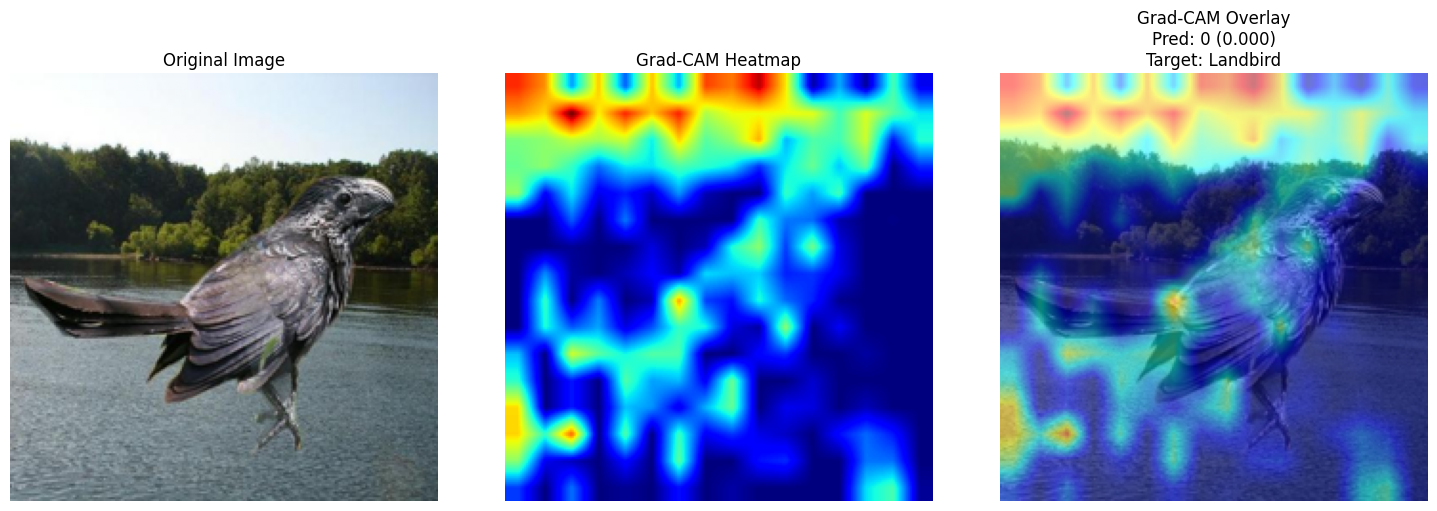


Processing: 004.Groove_billed_Ani/Groove_Billed_Ani_0037_1560.jpg
True label: 0 (Landbird), Background: 1 (Water)


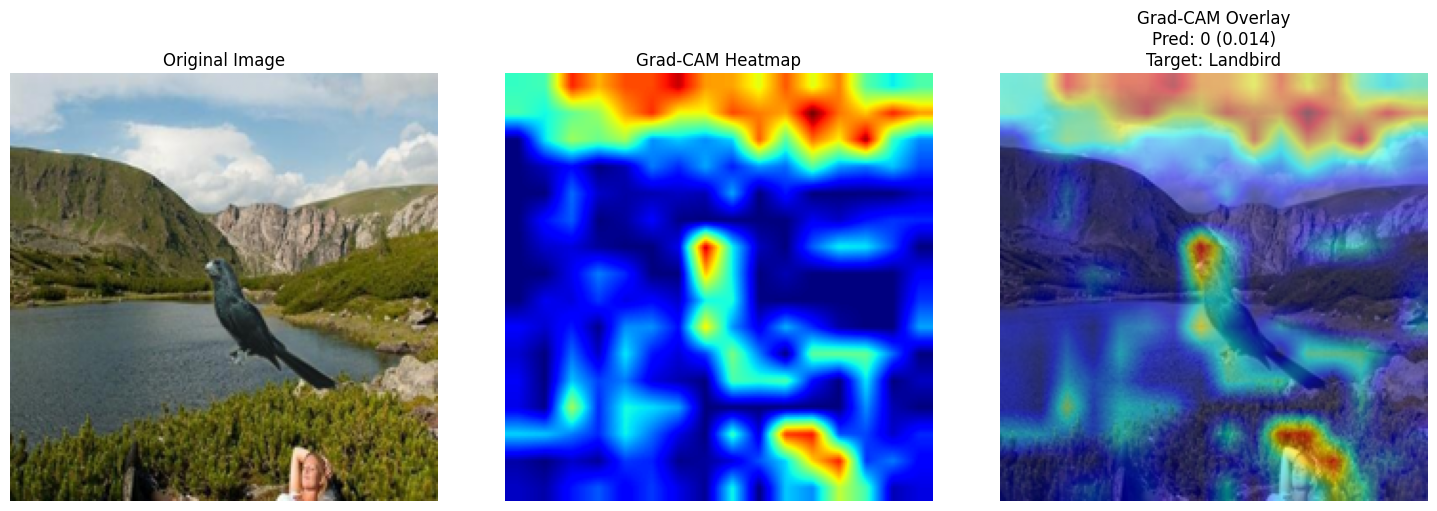


SUMMARY
File: 004.Groove_billed_Ani/Groove_Billed_Ani_0094_1540.jpg
  True: 0, Pred: 0 (0.000)
  Group: landbird_on_water

File: 004.Groove_billed_Ani/Groove_Billed_Ani_0037_1560.jpg
  True: 0, Pred: 0 (0.014)
  Group: landbird_on_water



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as transforms

class DINOv2GradCAMWrapper(nn.Module):
    """
    Wrapper for DINOv2 + linear head that makes Grad-CAM work properly
    """
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        # Get features from backbone
        features = self.backbone.forward_features(x)
        # Extract CLS token
        cls_token = features["x_norm_clstoken"]  # [B, 384]
        # Pass through head
        logits = self.head(cls_token)  # [B, 1]
        return logits

def reshape_transform_dinov2(tensor, height=16, width=16):
    """
    Reshape transform for DINOv2 ViT-S/14
    Input: tensor of shape [batch_size, num_patches + 1, hidden_dim]
    Output: tensor of shape [batch_size, hidden_dim, height, width]
    """
    # Remove CLS token (first token)
    if tensor.dim() == 3:
        tensor = tensor[:, 1:, :]  # Remove CLS token

    # Reshape patch tokens to spatial grid
    batch_size, num_patches, hidden_dim = tensor.shape

    # For ViT-S/14: 224/14 = 16, so we have 16x16 patches
    assert num_patches == height * width, f"Expected {height*width} patches, got {num_patches}"

    # Reshape to [batch_size, height, width, hidden_dim] then permute
    result = tensor.reshape(batch_size, height, width, hidden_dim)
    result = result.permute(0, 3, 1, 2)  # [batch_size, hidden_dim, height, width]

    return result

class DINOv2GradCAMVisualizer:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = self._load_model(model_path)
        self.transform = self._get_transform()

    def _load_model(self, model_path):
        """Load the trained DINOv2 model"""
        # Load backbone
        backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

        # Create head (adjust input features if needed)
        head = nn.Linear(384, 1)  # DINOv2-S has 384 features

        # Wrap model
        model = DINOv2GradCAMWrapper(backbone, head)

        # Load trained weights
        checkpoint = torch.load(model_path, map_location=self.device)

        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint

        # Load state dict
        model.load_state_dict(state_dict, strict=False)
        model = model.to(self.device)
        model.eval()

        return model

    def _get_transform(self):
        """Get preprocessing transform for DINOv2"""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def load_image(self, img_path):
        """Load and preprocess image"""
        image = Image.open(img_path).convert('RGB')

        # Keep original for visualization
        original_image = np.array(image.resize((224, 224))) / 255.0

        # Preprocess for model
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        return input_tensor, original_image

    def generate_gradcam(self, input_tensor, target_class=None, layer_name='blocks.-2.norm1'):
        """Generate Grad-CAM heatmap"""
        # Define target layers - we'll hook into the second-to-last transformer block
        if layer_name == 'blocks.-2.norm1':
            target_layers = [self.model.backbone.blocks[-2].norm1]
        elif layer_name == 'blocks.-1.norm1':
            target_layers = [self.model.backbone.blocks[-1].norm1]
        elif layer_name == 'blocks.-2.attn':
            target_layers = [self.model.backbone.blocks[-2].attn]
        else:
            # Default to second-to-last norm layer
            target_layers = [self.model.backbone.blocks[-2].norm1]

        # Create GradCAM object
        cam = GradCAM(
            model=self.model,
            target_layers=target_layers,
            reshape_transform=reshape_transform_dinov2
        )

        # Define target
        if target_class is not None:
            targets = [ClassifierOutputTarget(target_class)]
        else:
            # Use predicted class
            with torch.no_grad():
                output = self.model(input_tensor)
                predicted_class = int(torch.sigmoid(output) > 0.5)
            targets = [ClassifierOutputTarget(predicted_class)]

        # Generate CAM
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

        # Return the first (and only) image's CAM
        return grayscale_cam[0, :]

    def visualize_gradcam(self, img_path, target_class=None, layer_name='blocks.-2.norm1',
                         save_path=None, show_plot=True):
        """Complete pipeline to visualize Grad-CAM"""
        # Load image
        input_tensor, original_image = self.load_image(img_path)

        # Get model prediction
        with torch.no_grad():
            output = self.model(input_tensor)
            prediction_prob = torch.sigmoid(output).item()
            predicted_class = int(prediction_prob > 0.5)

        # Generate Grad-CAM
        try:
            grayscale_cam = self.generate_gradcam(input_tensor, target_class, layer_name)

            # Create visualization
            visualization = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)

            if show_plot:
                # Plot results
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                # Original image
                axes[0].imshow(original_image)
                axes[0].set_title('Original Image')
                axes[0].axis('off')

                # Heatmap
                axes[1].imshow(grayscale_cam, cmap='jet')
                axes[1].set_title('Grad-CAM Heatmap')
                axes[1].axis('off')

                # Overlay
                axes[2].imshow(visualization)
                target_used = target_class if target_class is not None else predicted_class
                class_name = "Waterbird" if target_used == 1 else "Landbird"
                axes[2].set_title(f'Grad-CAM Overlay\nPred: {predicted_class} ({prediction_prob:.3f})\nTarget: {class_name}')
                axes[2].axis('off')

                plt.tight_layout()

                if save_path:
                    plt.savefig(save_path, dpi=150, bbox_inches='tight')

                plt.show()

            return {
                'original_image': original_image,
                'heatmap': grayscale_cam,
                'visualization': visualization,
                'prediction': predicted_class,
                'prediction_prob': prediction_prob
            }

        except Exception as e:
            print(f"Error generating Grad-CAM: {str(e)}")
            print(f"Input tensor shape: {input_tensor.shape}")
            return None

def analyze_worst_group_samples(model_path, data_root, metadata_csv, device='cuda'):
    """
    Analyze worst-group samples from Waterbirds dataset
    """
    # Initialize visualizer
    visualizer = DINOv2GradCAMVisualizer(model_path, device)

    # Load metadata
    df = pd.read_csv(metadata_csv)

    # Filter test set
    test_df = df[df['split'] == 2].copy()

    # Identify worst-group samples
    # Group 1: Waterbirds on land (y=1, place=0)
    waterbird_on_land = test_df[(test_df['y'] == 1) & (test_df['place'] == 0)]

    # Group 2: Landbirds on water (y=0, place=1)
    landbird_on_water = test_df[(test_df['y'] == 0) & (test_df['place'] == 1)]

    print(f"Waterbirds on land: {len(waterbird_on_land)} samples")
    print(f"Landbirds on water: {len(landbird_on_water)} samples")

    # Sample 2 from each group
    samples_group1 = waterbird_on_land.head(2)
    samples_group2 = landbird_on_water.head(2)

    results = []

    print("\n" + "="*50)
    print("ANALYZING WORST-GROUP SAMPLES")
    print("="*50)

    # Process Group 1: Waterbirds on land
    print(f"\n--- GROUP 1: Waterbirds on Land ---")
    for idx, row in samples_group1.iterrows():
        img_path = f"{data_root}/{row['img_filename']}"
        print(f"\nProcessing: {row['img_filename']}")
        print(f"True label: {row['y']} (Waterbird), Background: {row['place']} (Land)")

        result = visualizer.visualize_gradcam(
            img_path,
            target_class=int(row['y']),  # Use true class
            layer_name='blocks.-2.norm1',
            save_path=f"gradcam_waterbird_land_{idx}.png"
        )

        if result:
            results.append({
                'filename': row['img_filename'],
                'true_label': row['y'],
                'background': row['place'],
                'prediction': result['prediction'],
                'prediction_prob': result['prediction_prob'],
                'group': 'waterbird_on_land'
            })

    # Process Group 2: Landbirds on water
    print(f"\n--- GROUP 2: Landbirds on Water ---")
    for idx, row in samples_group2.iterrows():
        img_path = f"{data_root}/{row['img_filename']}"
        print(f"\nProcessing: {row['img_filename']}")
        print(f"True label: {row['y']} (Landbird), Background: {row['place']} (Water)")

        result = visualizer.visualize_gradcam(
            img_path,
            target_class=int(row['y']),  # Use true class
            layer_name='blocks.-2.norm1',
            save_path=f"gradcam_landbird_water_{idx}.png"
        )

        if result:
            results.append({
                'filename': row['img_filename'],
                'true_label': row['y'],
                'background': row['place'],
                'prediction': result['prediction'],
                'prediction_prob': result['prediction_prob'],
                'group': 'landbird_on_water'
            })

    return results, visualizer

# Example usage
if __name__ == "__main__":
    # Configuration
    MODEL_PATH = "/content/raman_irm_dinov2_linear_ramp250.pth"  # Update this path
    DATA_ROOT = "/content/waterbirds_data/waterbird"
    METADATA_CSV = "/content/waterbirds_data/waterbird/metadata.csv"
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")

    # Run analysis
    try:
        results, visualizer = analyze_worst_group_samples(
            MODEL_PATH, DATA_ROOT, METADATA_CSV, DEVICE
        )

        print(f"\n" + "="*50)
        print("SUMMARY")
        print("="*50)
        for result in results:
            print(f"File: {result['filename']}")
            print(f"  True: {result['true_label']}, Pred: {result['prediction']} ({result['prediction_prob']:.3f})")
            print(f"  Group: {result['group']}")
            print()

    except Exception as e:
        print(f"Error during analysis: {str(e)}")
        import traceback
        traceback.print_exc()

    # Example of single image analysis
    # single_result = visualizer.visualize_gradcam(
    #     "/path/to/single/image.jpg",
    #     target_class=1,  # Or None for predicted class
    #     layer_name='blocks.-2.norm1'
    # )

In [ ]:
single_result = visualizer.visualize_gradcam(
        "/content/waterbirds_data/waterbird/044.Frigatebird/Frigatebird_0062_43193.jpg",
        target_class=1,  # Or None for predicted class
        layer_name='blocks.-2.norm1'
    )

Error generating Grad-CAM: index 1 is out of bounds for dimension 0 with size 1
Input tensor shape: torch.Size([1, 3, 224, 224])


### try2 (partial work)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import matplotlib.patches as patches
from scipy import ndimage
from skimage import measure, morphology
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

class DINOv2GradCAMWrapper(nn.Module):
    """Wrapper for DINOv2 + linear head that makes Grad-CAM work properly"""
    def __init__(self, backbone, head):
        super().__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        features = self.backbone.forward_features(x)
        cls_token = features["x_norm_clstoken"]
        logits = self.head(cls_token)
        return logits

def reshape_transform_dinov2(tensor, height=16, width=16):
    """Reshape transform for DINOv2 ViT-S/14"""
    # Remove CLS token (first token)
    if tensor.dim() == 3:
        tensor = tensor[:, 1:, :]  # Remove CLS token

    batch_size, num_patches, hidden_dim = tensor.shape
    assert num_patches == height * width, f"Expected {height*width} patches, got {num_patches}"

    # Reshape to [batch_size, height, width, hidden_dim] then permute
    result = tensor.reshape(batch_size, height, width, hidden_dim)
    result = result.permute(0, 3, 1, 2)
    return result

class ModelComparator:
    def __init__(self, model_paths: Dict[str, str], device='cuda'):
        """
        Initialize with multiple model paths
        model_paths: dict like {'ERM': '/path/to/erm_model.pth', 'IRM': '/path/to/irm_model.pth'}
        """
        self.device = device
        self.models = {}
        self.model_names = list(model_paths.keys())
        self.model_paths = model_paths # Store paths to check later

        # Load all models
        for name, path in model_paths.items():
            print(f"Loading {name} model from {path}")
            self.models[name] = self._load_model(path)

        self.transform = self._get_transform()

    def _load_model(self, model_path):
        """Load a DINOv2 model"""
        # Load backbone
        backbone = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

        # Determine head output size based on model path (assuming filename convention)
        # Adjust this logic if your filenames or structure are different
        if 'erm' in model_path.lower():
            # Assuming ERM model was trained with 2 output classes for softmax
            head_output_size = 2
        elif 'irm' in model_path.lower():
             # Assuming IRM model was trained with 1 output class for BCEWithLogits
             head_output_size = 1
        else:
             # Default or add more conditions for other models
             print(f"Warning: Could not determine head size for {model_path}, defaulting to 1.")
             head_output_size = 1

        # Create head with determined size
        head = nn.Linear(384, head_output_size)  # DINOv2-S has 384 features

        # Wrap model
        model = DINOv2GradCAMWrapper(backbone, head)

        # Load trained weights
        checkpoint = torch.load(model_path, map_location=self.device)

        # Handle different checkpoint formats
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint

        # Load state dict, allowing non-strict to handle potential minor mismatches
        # The primary mismatch (head size) should be fixed by the logic above
        model.load_state_dict(state_dict, strict=False)
        model = model.to(self.device)
        model.eval()

        return model

    def _get_transform(self):
        """Get preprocessing transform"""
        return transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def create_bird_mask(self, image_path: str, method='adaptive') -> np.ndarray:
        """
        Create a rough bird mask using various methods
        Returns binary mask where 1 = bird region, 0 = background
        """
        # Load original image
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error loading image: {image_path}")
            return np.zeros((224, 224), dtype=np.uint8) # Return empty mask on error

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_resized = cv2.resize(image_rgb, (224, 224))

        if method == 'adaptive':
            # Convert to different color spaces for better segmentation
            hsv = cv2.cvtColor(image_resized, cv2.COLOR_RGB2HSV)
            lab = cv2.cvtColor(image_resized, cv2.COLOR_RGB2LAB)

            # Create mask based on center region assumption (birds are usually centered)
            h, w = 224, 224
            center_mask = np.zeros((h, w), dtype=np.uint8)

            # Create elliptical center region
            center_y, center_x = h//2, w//2
            y, x = np.ogrid[:h, :w]
            ellipse_mask = ((x - center_x)**2 / (w//3)**2 + (y - center_y)**2 / (h//3)**2) <= 1

            # Combine with edge detection for refinement
            gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray, 50, 150)

            # Use morphological operations to create bird mask
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
            bird_mask = cv2.morphologyEx(ellipse_mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

            return bird_mask

        elif method == 'saliency':
            # Use simple saliency-based approach
            gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

            # Apply Gaussian blur and find high-contrast regions
            blurred = cv2.GaussianBlur(gray, (21, 21), 0)
            diff = cv2.absdiff(gray, blurred)

            # Threshold to get salient regions
            _, mask = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Focus on center regions
            h, w = mask.shape
            center_y, center_x = h//2, w//2
            y, x = np.ogrid[:h, :w]
            center_weight = np.exp(-((x - center_x)**2 + (y - center_y)**2) / (2 * (min(h, w)//4)**2))

            mask = (mask * center_weight > 0.3 * 255).astype(np.uint8)

            # Clean up mask
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
            mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
            mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

            return mask

        else:  # Simple center-based mask
            h, w = 224, 224
            center_y, center_x = h//2, w//2
            y, x = np.ogrid[:h, :w]
            # Create circular/elliptical mask in center
            mask = ((x - center_x)**2 / (w//3)**2 + (y - center_y)**2 / (h//3)**2) <= 1
            return mask.astype(np.uint8)


    def compute_background_activation(self, gradcam_heatmap: np.ndarray, bird_mask: np.ndarray) -> float:
        """
        Compute mean Grad-CAM activation in background regions
        """
        # Invert bird mask to get background mask
        background_mask = 1 - bird_mask

        # Ensure background_mask is boolean or uint8
        background_mask = background_mask.astype(bool)

        # Compute mean activation only in background regions
        if np.sum(background_mask) > 0:
            background_activation = np.mean(gradcam_heatmap[background_mask])
        else:
            background_activation = 0.0 # No background pixels

        return background_activation

    def generate_gradcam_for_model(self, model, input_tensor, target_class=None):
        """Generate Grad-CAM for a specific model"""
        # For DINOv2, target the output of the last transformer block's patch tokens
        # We need to hook into the forward pass to get this intermediate output
        # A simpler approach might be to get patch tokens via forward_features
        # and compute gradients manually, as attempted previously.
        # Let's try the manual approach again within this class.

        model.eval()
        input_tensor.requires_grad_(True)

        # Use forward_features to get the features after the backbone blocks
        features = model.backbone.forward_features(input_tensor)
        patch_tokens = features["x_norm_patchtokens"] # [B, N, D]
        cls_token = features["x_norm_clstoken"] # [B, D]

        # Pass the CLS token through the head to get logits
        logits = model.head(cls_token) # [B, num_classes]

        # Define the target for gradient computation based on model's output size
        if model.head.out_features == 1:
            # For binary classification with a single output (e.g., BCEWithLogits)
            # Target the single output logit
            target = logits # [B, 1]
        else:
            # For multi-class classification (e.g., Softmax with 2 outputs)
            # Target the logit of the specific class
            # If target_class is None, use the predicted class
            if target_class is None:
                predicted_class = torch.argmax(logits, dim=1).item()
                target = logits[:, predicted_class]
            else:
                 target = logits[:, target_class] # [B]


        # Clear previous gradients
        if patch_tokens.grad is not None:
             patch_tokens.grad.zero_()
        if input_tensor.grad is not None:
            input_tensor.grad.zero_()


        # Compute gradients of the target with respect to patch tokens
        # Use allow_unused=True to handle cases where patch_tokens are not directly
        # used in the final target computation through the head (which is common)
        # retain_graph=True is needed if we do multiple backward passes (not in this function, but potentially if this is called in a loop)
        gradients = torch.autograd.grad(outputs=target, inputs=patch_tokens, grad_outputs=torch.ones_like(target), retain_graph=True, allow_unused=True)[0]

        # Handle the case where gradients might be None
        if gradients is None:
            print(f"Warning: Gradients for patch_tokens are None.")
            return None, None # Return None for heatmap and predicted class


        activations = patch_tokens # [B, N, D]

        # Compute Grad-CAM weights (Global Average Pooling of gradients)
        weights = torch.mean(gradients, dim=1) # [B, D]

        # Compute CAM (weighted sum of activations)
        cam = torch.einsum('bd,bnd->bn', weights, activations) # [B, N]

        # Reshape CAM to spatial dimensions (H, W)
        h = w = int(math.sqrt(cam.shape[1]))
        cam = cam.reshape(cam.size(0), h, w) # [B, H, W]

        # Apply ReLU
        cam = F.relu(cam)

        # Normalize CAM to [0, 1]
        cam_min, cam_max = cam.min(), cam.max()
        if cam_max - cam_min > 1e-8:
            cam = (cam - cam_min) / (cam_max - cam_min)
        else:
            cam = torch.zeros_like(cam) # Handle case where CAM is all zeros


        # Get the single heatmap for the current image
        grayscale_cam = cam.squeeze(0).cpu().numpy() # [H, W]

        # Get predicted class for reporting
        with torch.no_grad():
             pred_prob = torch.sigmoid(logits).item() if model.head.out_features == 1 else torch.softmax(logits, dim=1)[0, 1].item() # Assuming class 1 is Waterbird
             predicted_class = int(pred_prob > 0.5) if model.head.out_features == 1 else torch.argmax(logits, dim=1).item()


        return grayscale_cam, predicted_class

    def load_and_preprocess_image(self, img_path):
        """Load and preprocess image"""
        image = Image.open(img_path).convert('RGB')
        original_image = np.array(image.resize((224, 224))) / 255.0
        input_tensor = self.transform(image).unsqueeze(0).to(self.device)
        return input_tensor, original_image

    def analyze_sample_images(self, sample_images: List[Dict], mask_method='adaptive') -> Dict:
        """
        Analyze a list of sample images
        sample_images: List of dicts with keys: 'path', 'true_label', 'group_name'
        """
        results = {
            'images': [],
            'gradcams': {model_name: [] for model_name in self.model_names},
            'background_activations': {model_name: [] for model_name in self.model_names},
            'predictions': {model_name: [] for model_name in self.model_names},
            'bird_masks': []
        }

        for sample in sample_images:
            img_path = sample['path']
            true_label = sample['true_label']
            group_name = sample['group_name']

            print(f"Processing: {img_path} ({group_name})")

            # Load image
            input_tensor, original_image = self.load_and_preprocess_image(img_path)

            # Create bird mask
            bird_mask = self.create_bird_mask(img_path, method=mask_method)

            # Store image data
            results['images'].append({
                'path': img_path,
                'original': original_image,
                'true_label': true_label,
                'group_name': group_name
            })
            results['bird_masks'].append(bird_mask)

            # Generate Grad-CAM for each model
            for model_name, model in self.models.items():
                # Pass true_label to target the correct class gradients
                gradcam, predicted_class = self.generate_gradcam_for_model(
                    model, input_tensor, target_class=true_label
                )

                if gradcam is not None:
                    # Compute background activation only if CAM was generated
                    bg_activation = self.compute_background_activation(gradcam, bird_mask)
                else:
                    bg_activation = np.nan # Indicate missing data

                # Get model prediction for reporting
                with torch.no_grad():
                    output = model(input_tensor)
                    if model.head.out_features == 1:
                         pred_prob = torch.sigmoid(output).item()
                         pred_class = int(pred_prob > 0.5)
                    else: # Assuming 2 output classes
                         pred_prob = torch.softmax(output, dim=1)[0, 1].item() # Probability of class 1 (Waterbird)
                         pred_class = torch.argmax(output, dim=1).item()


                # Store results
                results['gradcams'][model_name].append(gradcam) # Store None if gradcam failed
                results['background_activations'][model_name].append(bg_activation)
                results['predictions'][model_name].append({
                    'class': pred_class,
                    'probability': pred_prob
                })

        return results

    def create_comparison_montage(self, results: Dict, save_path: str = None, figsize=(20, 16)):
        """
        Create the full comparison montage with Grad-CAMs and background analysis
        Handles potential None values in gradcams list.
        """
        n_images = len(results['images'])
        n_models = len(self.model_names)

        # Filter out images for which no valid CAMs were generated for any model
        valid_indices = [i for i in range(n_images)
                         if all(results['gradcams'][model_name][i] is not None for model_name in self.model_names)]

        if not valid_indices:
            print("No valid Grad-CAMs generated for any image across all models. Cannot create montage.")
            return

        n_valid_images = len(valid_indices)
        print(f"Creating montage for {n_valid_images} valid images.")


        # Create figure with custom layout
        # Add space at the bottom for summary text/plot if needed
        fig = plt.figure(figsize=figsize)

        # Create grid: n_valid_images rows for images
        gs = fig.add_gridspec(n_valid_images, (n_models * 3), wspace=0.1, hspace=0.2)


        # Plot each image row
        for valid_idx, img_idx in enumerate(valid_indices):
            img_data = results['images'][img_idx]
            bird_mask = results['bird_masks'][img_idx]

            for model_idx, model_name in enumerate(self.model_names):
                col_offset = model_idx * 3

                # Original image (only for first model column)
                if model_idx == 0:
                    ax_orig = fig.add_subplot(gs[valid_idx, col_offset])
                    ax_orig.imshow(img_data['original'])

                    # Add title with group info
                    title = f"{img_data['group_name']}\nTrue: {'Water' if img_data['true_label']==1 else 'Land'}bird"
                    ax_orig.set_title(title, fontsize=10, fontweight='bold')
                    ax_orig.axis('off')

                # Grad-CAM heatmap
                ax_heatmap = fig.add_subplot(gs[valid_idx, col_offset + 1])
                gradcam = results['gradcams'][model_name][img_idx] # Use original index
                im = ax_heatmap.imshow(gradcam, cmap='jet', alpha=0.8)

                # Add bird mask outline
                contours = measure.find_contours(bird_mask, 0.5)
                for contour in contours:
                    ax_heatmap.plot(contour[:, 1], contour[:, 0], 'w--', linewidth=1.5, alpha=0.8)

                pred = results['predictions'][model_name][img_idx] # Use original index
                bg_act = results['background_activations'][model_name][img_idx] # Use original index

                if valid_idx == 0:  # Add model name as title for first row
                    ax_heatmap.set_title(f"{model_name}\nBG Activation: {bg_act:.3f}",
                                       fontsize=10, fontweight='bold')
                else:
                    ax_heatmap.set_title(f"BG: {bg_act:.3f}", fontsize=9)

                ax_heatmap.axis('off')

                # Grad-CAM overlay
                ax_overlay = fig.add_subplot(gs[valid_idx, col_offset + 2])
                overlay = show_cam_on_image(img_data['original'], gradcam, use_rgb=True)
                ax_overlay.imshow(overlay)

                pred_text = f"Pred: {pred['class']} ({pred['probability']:.2f})"
                ax_overlay.set_title(pred_text, fontsize=9)
                ax_overlay.axis('off')

        # Add column titles
        for model_idx, model_name in enumerate(self.model_names):
            col_offset = model_idx * 3
            # Original title added above in the first column
            fig.text((col_offset + 0.5) / (n_models * 3), 1.00, # Adjust y position as needed
                     f'{model_name}', va='center', ha='center', fontsize=12, fontweight='bold', transform=fig.transFigure)
            fig.text((col_offset + 1.5) / (n_models * 3), 1.00, # Adjust y position as needed
                     'Grad-CAM Heatmap', va='center', ha='center', fontsize=12, fontweight='bold', transform=fig.transFigure)
            fig.text((col_offset + 2.5) / (n_models * 3), 1.00, # Adjust y position as needed
                     'Grad-CAM Overlay', va='center', ha='center', fontsize=12, fontweight='bold', transform=fig.transFigure)



        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for titles

        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')

        plt.show()

    def plot_background_activation_comparison(self, results: Dict):
        """Plot boxplot comparing background activations per model and group"""
        data = []
        for model_name in self.model_names:
            for i in range(len(results['images'])):
                 img_data = results['images'][i]
                 bg_act = results['background_activations'][model_name][i]
                 if not np.isnan(bg_act): # Exclude images where CAM failed
                    data.append({
                        'Model': model_name,
                        'Background Activation': bg_act,
                        'Group': img_data['group_name']
                    })

        if not data:
            print("No data available for background activation comparison plot.")
            return

        df_plot = pd.DataFrame(data)

        plt.figure(figsize=(10, 6))
        sns.boxplot(data=df_plot, x='Group', y='Background Activation', hue='Model')
        plt.title('Comparison of Background Activation')
        plt.ylabel('Mean Grad-CAM Activation in Background')
        plt.grid(axis='y', linestyle='--')
        plt.show()

In [ ]:
import pandas as pd
import os

# =====================================================================
# STEP 1: CONFIGURE YOUR PATHS AND MODEL FILES
# =====================================================================

# Update these paths to match your setup
DATA_ROOT = "/content/waterbirds_data/waterbird"
METADATA_CSV = "/content/waterbirds_data/waterbird/metadata.csv"

# IMPORTANT: Update these with your actual model paths
MODEL_PATHS = {
    'ERM': '/content/erm_dinov2_linear_kaggle.pth',          # Replace with your ERM model path
    'IRM': '/content/raman_irm_dinov2_linear_ramp250.pth',          # Replace with your IRM/SSL model path
    # Add more models if needed:
    # 'GroupDRO': '/path/to/groupdro_model.pth',
}

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def select_worst_group_samples(metadata_csv, data_root, n_per_group=2):
    """
    Select sample images from worst-case groups in Waterbirds dataset
    """
    # Load metadata
    df = pd.read_csv(metadata_csv)
    test_df = df[df['split'] == 2].copy()  # Test set only

    # Define worst-case groups
    # Group 1: Waterbirds on land background (y=1, place=0)
    waterbird_on_land = test_df[(test_df['y'] == 1) & (test_df['place'] == 0)]

    # Group 2: Landbirds on water background (y=0, place=1)
    landbird_on_water = test_df[(test_df['y'] == 0) & (test_df['place'] == 1)]

    print(f"Available samples:")
    print(f"  Waterbirds on land: {len(waterbird_on_land)}")
    print(f"  Landbirds on water: {len(landbird_on_water)}")

    # Sample images from each group
    sample_images = []

    # Sample from Group 1
    for idx, row in waterbird_on_land.head(n_per_group).iterrows():
        sample_images.append({
            'path': os.path.join(data_root, row['img_filename']),
            'true_label': int(row['y']),
            'group_name': 'Waterbird on Land',
            'background': int(row['place']),
            'filename': row['img_filename']
        })

    # Sample from Group 2
    for idx, row in landbird_on_water.head(n_per_group).iterrows():
        sample_images.append({
            'path': os.path.join(data_root, row['img_filename']),
            'true_label': int(row['y']),
            'group_name': 'Landbird on Water',
            'background': int(row['place']),
            'filename': row['img_filename']
        })

    return sample_images


In [ ]:
def run_gradcam_comparison():
    """
    Main function to run the complete Grad-CAM comparison analysis
    """
    print("🚀 Starting Grad-CAM Model Comparison Analysis")
    print("=" * 60)

    # Step 3a: Initialize the comparator
    print("📋 Step 1: Loading models...")
    try:
        comparator = ModelComparator(MODEL_PATHS, device=DEVICE)
        print(f"✅ Successfully loaded {len(MODEL_PATHS)} models")
    except Exception as e:
        print(f"❌ Error loading models: {e}")
        return None

    # Step 3b: Select sample images
    print("\n📋 Step 2: Selecting sample images...")
    try:
        sample_images = select_worst_group_samples(METADATA_CSV, DATA_ROOT, n_per_group=2)
        print(f"✅ Selected {len(sample_images)} sample images")

        # Print selected images
        for i, img in enumerate(sample_images):
            print(f"  {i+1}. {img['group_name']}: {img['filename']}")

    except Exception as e:
        print(f"❌ Error selecting samples: {e}")
        return None

    # Step 3c: Analyze images
    print("\n📋 Step 3: Generating Grad-CAM visualizations...")
    try:
        results = comparator.analyze_sample_images(sample_images, mask_method='adaptive')
        print("✅ Grad-CAM analysis complete")
    except Exception as e:
        print(f"❌ Error during Grad-CAM analysis: {e}")
        import traceback
        traceback.print_exc()
        return None

    # Step 3d: Create comparison montage
    print("\n📋 Step 4: Creating comparison montage...")
    try:
        comparator.create_comparison_montage(
            results,
            save_path='gradcam_comparison_montage.png',
            figsize=(20, 16)
        )
        print("✅ Montage saved as 'gradcam_comparison_montage.png'")
    except Exception as e:
        print(f"❌ Error creating montage: {e}")
        import traceback
        traceback.print_exc()
        return None

    # Step 3e: Print summary statistics
    print("\n📊 SUMMARY STATISTICS")
    print("=" * 40)

    model_names = list(MODEL_PATHS.keys())
    for model_name in model_names:
        bg_activations = results['background_activations'][model_name]
        mean_bg = np.mean(bg_activations)
        std_bg = np.std(bg_activations)
        print(f"{model_name:>10}: Mean BG Activation = {mean_bg:.4f} ± {std_bg:.4f}")

    # Show prediction accuracies
    print(f"\n📈 PREDICTIONS vs TRUE LABELS")
    print("=" * 40)
    for i, img in enumerate(sample_images):
        print(f"\n{img['group_name']} - {img['filename']}")
        print(f"  True label: {img['true_label']} ({'Waterbird' if img['true_label']==1 else 'Landbird'})")

        for model_name in model_names:
            pred = results['predictions'][model_name][i]
            correct = "✅" if pred['class'] == img['true_label'] else "❌"
            print(f"  {model_name:>10}: {pred['class']} ({pred['probability']:.3f}) {correct}")

    print(f"\n🎉 Analysis complete! Check 'gradcam_comparison_montage.png' for results.")

    return results, comparator

In [ ]:
if __name__ == "__main__":
    # Run the complete analysis
    results, comparator = run_gradcam_comparison()

# =====================================================================
# ALTERNATIVE: MANUAL STEP-BY-STEP EXECUTION
# =====================================================================

# If you prefer to run step by step manually:

# # Step 1: Initialize comparator
# comparator = ModelComparator(MODEL_PATHS, device=DEVICE)

# # Step 2: Select samples
# sample_images = select_worst_group_samples(METADATA_CSV, DATA_ROOT, n_per_group=2)

# # Step 3: Analyze
# results = comparator.analyze_sample_images(sample_images, mask_method='adaptive')

# # Step 4: Create montage
# comparator.create_comparison_montage(results, save_path='my_gradcam_comparison.png')

# =====================================================================
# ADVANCED OPTIONS
# =====================================================================

# Option 1: Analyze specific images
def analyze_specific_images():
    """Analyze specific images instead of automatic selection"""

    specific_images = [
        {
            'path': '/content/waterbirds_data/waterbird/003.Sooty_Albatross/Sooty_Albatross_0054_796347.jpg',
            'true_label': 1,  # 1 for waterbird, 0 for landbird
            'group_name': 'Custom Group 1',
        },
        {
            'path': '/content/waterbirds_data/waterbird/004.Groove_billed_Ani/Groove_Billed_Ani_0012_1784.jpg',
            'true_label': 0,
            'group_name': 'Custom Group 2',
        },
        # Add more images...
    ]

    comparator = ModelComparator(MODEL_PATHS, device=DEVICE)
    results = comparator.analyze_sample_images(specific_images)
    comparator.create_comparison_montage(results, save_path='custom_analysis.png')

# Option 2: Try different mask methods
def try_different_masks():
    """Try different bird mask generation methods"""

    comparator = ModelComparator(MODEL_PATHS, device=DEVICE)
    sample_images = select_worst_group_samples(METADATA_CSV, DATA_ROOT, n_per_group=1)

    for mask_method in ['adaptive', 'saliency', 'center']:
        print(f"\nTrying mask method: {mask_method}")
        results = comparator.analyze_sample_images(sample_images, mask_method=mask_method)
        comparator.create_comparison_montage(
            results,
            save_path=f'gradcam_comparison_{mask_method}.png'
        )

🚀 Starting Grad-CAM Model Comparison Analysis
📋 Step 1: Loading models...
Loading ERM model from /content/erm_dinov2_linear_kaggle.pth


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Loading IRM model from /content/raman_irm_dinov2_linear_ramp250.pth


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


✅ Successfully loaded 2 models

📋 Step 2: Selecting sample images...
Available samples:
  Waterbirds on land: 642
  Landbirds on water: 2255
✅ Selected 4 sample images
  1. Waterbird on Land: 001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg
  2. Waterbird on Land: 001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg
  3. Landbird on Water: 004.Groove_billed_Ani/Groove_Billed_Ani_0094_1540.jpg
  4. Landbird on Water: 004.Groove_billed_Ani/Groove_Billed_Ani_0037_1560.jpg

📋 Step 3: Generating Grad-CAM visualizations...
Processing: /content/waterbirds_data/waterbird/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg (Waterbird on Land)
Processing: /content/waterbirds_data/waterbird/001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg (Waterbird on Land)
Processing: /content/waterbirds_data/waterbird/004.Groove_billed_Ani/Groove_Billed_Ani_0094_1540.jpg (Landbird on Water)
Processing: /content/waterbirds_data/waterbird/004.Groove_billed_Ani